In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import sys
import os
import pandas as pd

DATA_PATH = r"C:\Projects\FIN-525\data\daily\us_equities.csv.gz"

eod_data = pd.read_csv(DATA_PATH)
valid_rets = eod_data.pct_change().dropna()
valid_rets.shape

(178, 1054)

<AxesSubplot:>

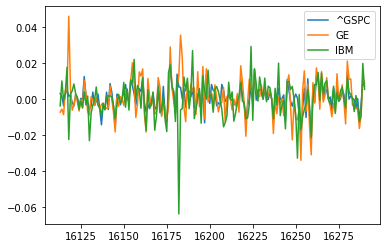

In [4]:
valid_rets.iloc[:, 1:4].plot()

In [24]:
N = 100
T = 360
mu = 0
sigma = 1
q = N/T

def get_rets(mu, sigma, N, T):
    # generates returns
    rets = np.random.normal(mu, sigma, (T, N))
    scov = np.cov(rets, rowvar=False)
    scorr = np.corrcoef(rets, rowvar=False)
    return rets, scov, scorr

def get_eigenvalues(mu, sigma, N, T, niter= 1000):
    cov_eig = []
    corr_eig = []
    for i in range(niter):
        rets, scov, scorr = get_rets(mu, sigma, N, T)
        cov_eig.append(np.linalg.eigvals(scov))
        corr_eig.append(np.linalg.eigvals(scorr))
    return np.array(cov_eig).flatten(), np.array(corr_eig).flatten()

def get_eigenvalues_parallel(mu, sigma, N, T, niter= 1000):
    cov_eig = []
    corr_eig = []
    for i in range(niter):
        rets, scov, scorr = get_rets(mu, sigma, N, T)
        cov_eig.append(np.linalg.eigvals(scov))
        corr_eig.append(np.linalg.eigvals(scorr))
    return np.array(cov_eig).flatten(), np.array(corr_eig).flatten()

def compute_lam_bounds(q):
    lplus = np.square(1 + np.sqrt(q))
    lminus = np.square(1 - np.sqrt(q))
    return lminus, lplus

def marcneko_pastur(q, n_points=100):
    lminus, lplus = compute_lam_bounds(q)
    l_grid = np.linspace(lminus, lplus, n_points)
    vals = np.divide(1/q, 2 * np.pi) * np.divide(np.sqrt((lplus - l_grid) * (l_grid - lminus)), l_grid)
    return l_grid, vals

def clip_eigs(eigs, q):
    lminus, lplus = compute_lam_bounds(q)
    slice_mask = (eigs >= lminus) & (eigs <= lplus)
    eigs[slice_mask] = np.mean(eigs[slice_mask])
    return eigs

def clean_matrix_clipping(corrmat, q):
    eigvals, eigvecs = np.linalg.eigh(corrmat)
    clean_eigs = clip_eigs(eigvals, q)
    reconstructed_corrmat = np.matmul(np.matmul(eigvecs, np.diag(clean_eigs)), np.linalg.inv(eigvecs))
    np.fill_diagonal(reconstructed_corrmat, 1)
    return reconstructed_corrmat
    


In [16]:
compute_lam_bounds(q)

(0.22368522438831798, 2.3318703311672375)

In [17]:
rets, scov, scorr = get_rets(mu, sigma, N, T)

Lets check how eigen decomposition works

In [18]:
eigvals, eigvecs = np.linalg.eigh(scorr)

In [19]:
cov_eig, corr_eig = get_eigenvalues(mu, sigma, N, T, niter= 1000)

In [20]:
l_grid, theoretical_eig_dist = marcneko_pastur(q)

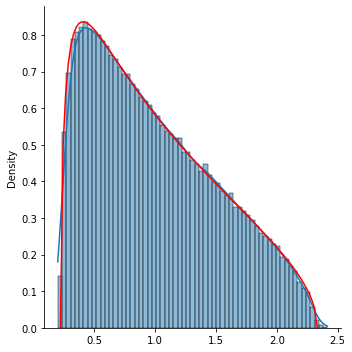

In [21]:
sns.displot(corr_eig, kde=True, stat='density')
plt.plot(l_grid, theoretical_eig_dist, color='r')

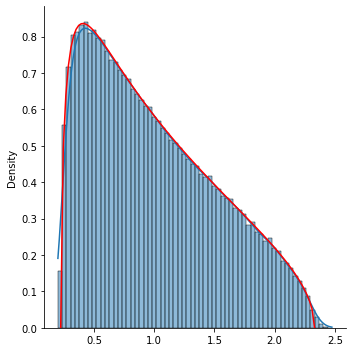

In [22]:
sns.displot(cov_eig, kde=True, stat='density')
plt.plot(l_grid, theoretical_eig_dist, color='r')

Lets check on real data

<AxesSubplot:>

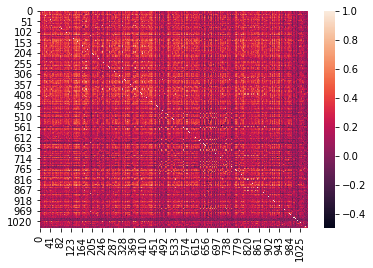

In [28]:
emp_corr = np.corrcoef(valid_rets, rowvar=False)
emp_cov = np.corrcoef(valid_rets, rowvar=False)
sns.heatmap(emp_corr)

In [213]:
selected_assets = ['IBM', 'GE', 'GM','HD', "AMD", "BTO", "AES", "DOW", "HP"]
# sel_rets = eod_data[selected_assets].dropna()
# N = len(selected_assets)
# Tmax = sel_rets.shape[0]
N = 10
T = 30
sel_rets = eod_data.sample(N, axis=1).pct_change().dropna()
last_sel_rets = sel_rets.tail(T)

q = N/Tmax

<AxesSubplot:>

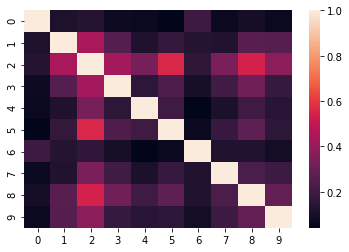

In [214]:
emp_corr = np.corrcoef(sel_rets, rowvar=False)
emp_cov = np.cov(sel_rets, rowvar=False)
sns.heatmap(emp_corr)

In [215]:
compute_lam_bounds(q)

(0.7927547259424735, 1.231283735595988)

<AxesSubplot:>

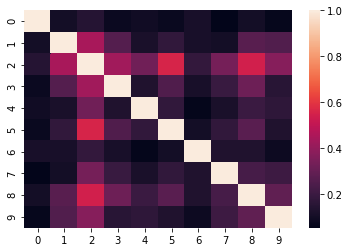

In [216]:
clean_corr = clean_matrix_clipping(emp_corr, q)
sns.heatmap(clean_corr)

In [217]:
np.linalg.norm(emp_corr - clean_corr)

0.18349896903335824

Lets try this on a rolling basis  -- that is, on everyday look back T period and retrieve eigenvalues

In [218]:
def retrieve_eigs(mat):
    scorr = np.corrcoef(mat.to_numpy(), rowvar=False)
    eigvals = np.linalg.eigvals(scorr)
    return eigvals

In [219]:
vals = np.array([])
counter = 0
for i, rolling_window in enumerate(sel_rets.tail(600).rolling(T)):
#     print(rolling_window.corr())
#     print(type(rolling_window))
    if rolling_window.shape[0] == T:
        try:
            vals = np.append(vals, retrieve_eigs(rolling_window))
        except:
            counter += 1
            continue
        

In [220]:
counter

0

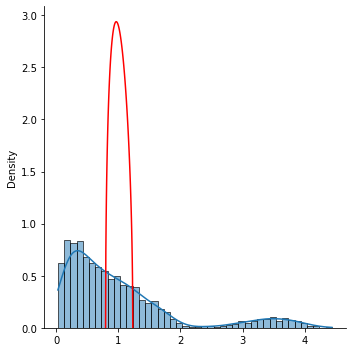

In [221]:
lgrid, lams = marcneko_pastur(q)
sns.displot(vals, kde=True, stat='density')
plt.plot(lgrid, lams, color='r')

In [32]:
np.linalg.eigvals(np.eye(scorr.shape[0]))

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [33]:
np.linalg.eigvals(scov)

array([5.9734506 , 3.0267699 , 4.83864892, 4.6827952 , 3.34660951,
       3.56228942, 3.77745815, 4.32537279, 4.18636751, 4.04237992])

In [34]:
np.linalg.eigvals(scorr)

array([1.36212455, 1.20265961, 0.73873488, 1.09746126, 1.04953195,
       1.01421829, 0.9628345 , 0.81644387, 0.86989343, 0.88609766])

<AxesSubplot:>

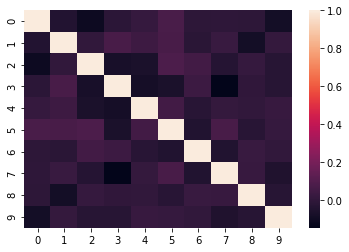

In [25]:
sns.heatmap(np.corrcoef(rets, rowvar=False))

In [22]:
np.cov(rets.T).shape

(10, 10)

<AxesSubplot:ylabel='Count'>

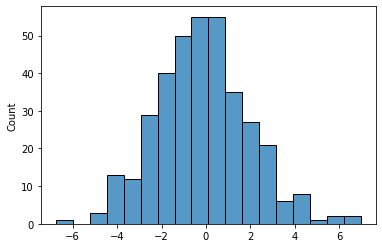

In [12]:
sns.histplot(rets[:, 0], )